<a href="https://colab.research.google.com/github/AlekseiMikhalev/Data-Science-Projects/blob/master/ULMFiT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__Template for ULMFiT sentiment analysis__

In [0]:
#Importing Libraries 

from fastai.metrics import accuracy #explain why?
from fastai.text import * #explain why?
from fastai import * #explain why?
import gc #explain why?
import os #explain why?
import pandas as pd #explain why?
import numpy as np #explain why?

In [3]:
#Open the dataset and explore it
tweets = pd.read_csv('/content/Tweets.csv')
print('Shape: ', tweets.shape)
tweets.head()

Shape:  (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
#Check missing data
def check_missing_data(df):
    # check for any missing data in the df (display in descending order)
    return df.isnull().sum().sort_values(ascending=False)

In [8]:
check_missing_data(tweets)

negativereason_gold             14608
airline_sentiment_gold          14600
tweet_coord                     13621
negativereason                   5462
user_timezone                    4820
tweet_location                   4733
negativereason_confidence        4118
tweet_created                       0
text                                0
retweet_count                       0
name                                0
airline                             0
airline_sentiment_confidence        0
airline_sentiment                   0
tweet_id                            0
dtype: int64

In [0]:
#Droping 3 columns which are almost empty
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

###__Data visualization__

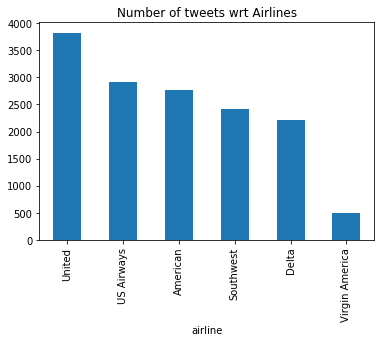

In [10]:
tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Number of tweets wrt Airlines')
plt.show()

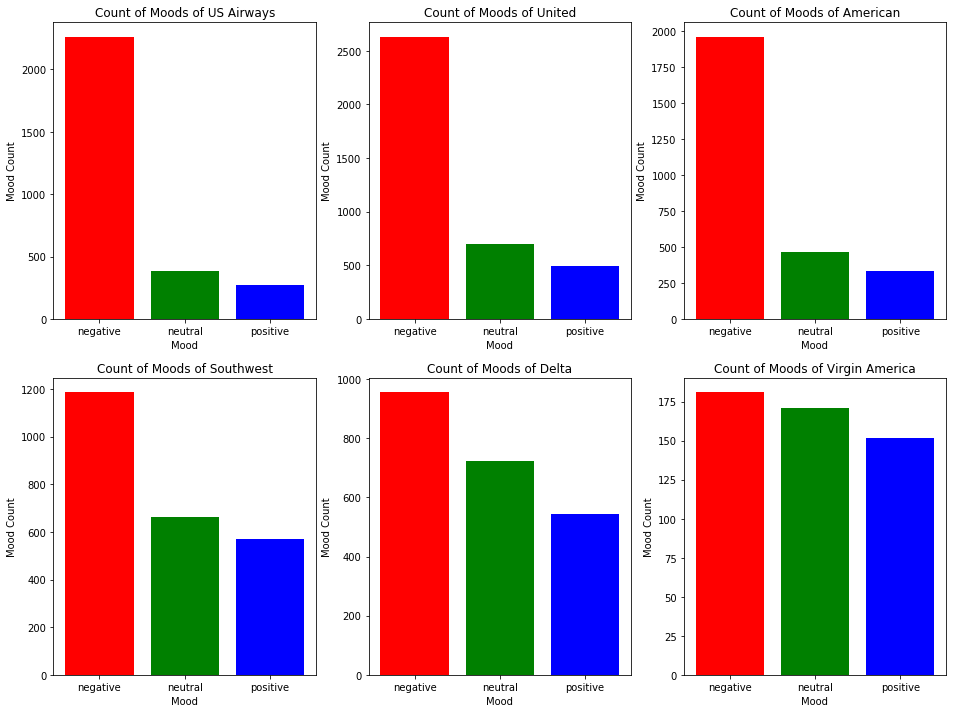

In [11]:
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

plt.figure(1,figsize=(16, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=tweets[tweets['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

###__Wordclouds__ of the __Positive__, __Negative__, __Neutral__ - airline_sentiment

In [0]:
from wordcloud import WordCloud,STOPWORDS  #Explain what is wordcloud and why you import it? 

def generate_wordcloud(text, title): #Explain this function?
    wordcloud = WordCloud(relative_scaling = 1.0,stopwords = STOPWORDS, background_color='black').generate(text)
    fig,ax = plt.subplots(1,1,figsize=(14,18))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.title(title)
    plt.show()

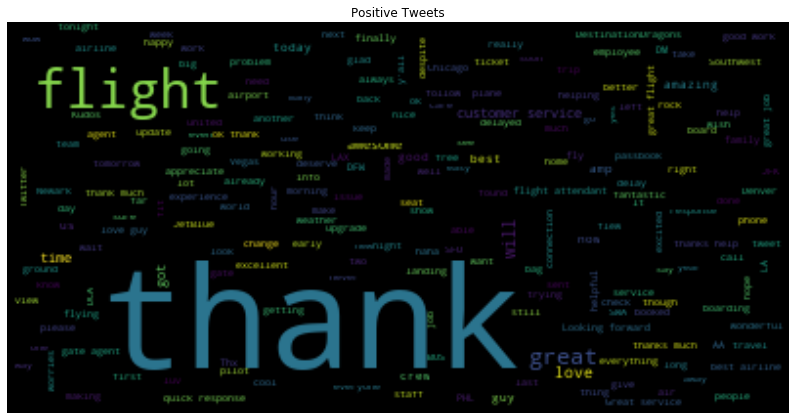

In [13]:
words_positive = ' '.join(tweets[tweets['airline_sentiment']=='positive']['text'])
cleaned_word_positive = " ".join([word for word in words_positive.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

generate_wordcloud(cleaned_word_positive, 'Positive Tweets')

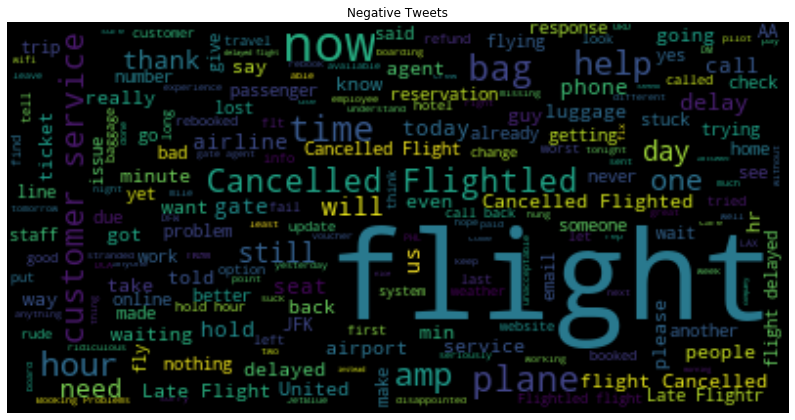

In [14]:
words_negative = ' '.join(tweets[tweets['airline_sentiment']=='negative']['text'])
cleaned_word_negative = " ".join([word for word in words_negative.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

generate_wordcloud(cleaned_word_negative, 'Negative Tweets')

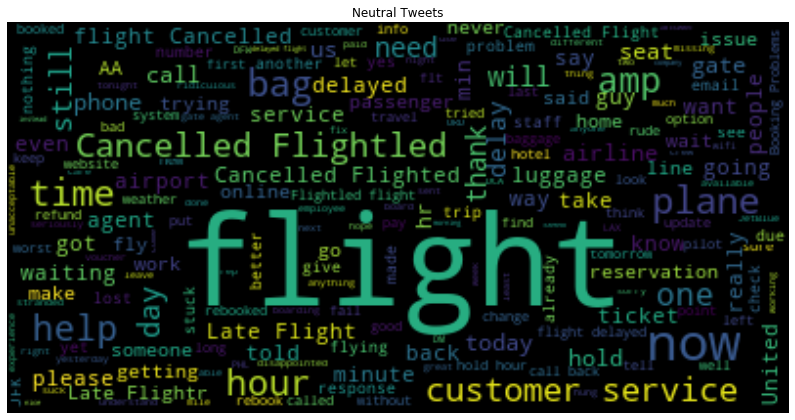

In [15]:
words_neutral = ' '.join(tweets[tweets['airline_sentiment']=='neutral']['text'])
cleaned_word_neutral = " ".join([word for word in words_neutral.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

generate_wordcloud(cleaned_word_negative, 'Neutral Tweets')

###__Data Cleaning__

In [17]:
import re #Explain why import this?
import nltk #And this
nltk.download('stopwords')
from nltk.corpus import stopwords #And this and each function below

def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

tweets['clean_tweet']=tweets['text'].apply(lambda x: tweet_to_words(x))
tweets['Tweet_length']=tweets['text'].apply(lambda x: clean_tweet_length(x))
tweets['sentiment']=tweets['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#Split data into training and validation set
df_trn, df_val = train_test_split(tweets, stratify = tweets['airline_sentiment'], test_size = 0.4, random_state = 678) #Explain why 678

###__ULMFiT Model__


In [20]:
#Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.4) #explain

In [24]:
#Train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2) #Explain why this learning rate has been chosen

epoch,train_loss,valid_loss,accuracy,time
0,5.920623,4.275937,0.474256,00:36


In [26]:
#Unfreeze the learner object and train
learn.unfreeze()
learn.fit_one_cycle(7, slice(1e-2, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.505138,0.482198,0.810714,00:54
1,0.530932,0.489904,0.810863,00:54
2,0.515965,0.476172,0.811533,00:54
3,0.505761,0.469507,0.811533,00:54
4,0.498354,0.470698,0.810714,00:53
5,0.493418,0.469380,0.811161,00:54
6,0.489438,0.469218,0.811161,00:54


In [0]:
learn.save_encoder('ft_enc')